In [2]:
import xgboost
import shap
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import plots as plots
import pickle
import lime
import lime.lime_tabular

/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load data and models

In [3]:
data = pickle.load(open('xgb_models/data0.pkl', 'rb'))
model = pickle.load(open('xgb_models/opt_XGB_YN0.pkl', 'rb'))

X_train_target = data['X_train_target']
X_test_target = data['X_test_target']
X = data['X']

X_train = data['X_train']
X_test = data['X_test']
X_val = data['X_val']
X_all = data['X_all']

y_train = data['y_train']
y_test = data['y_test']
y_val = data['y_val']
y = data['y']

## Accuracy

In [4]:
print('Training score: %.2f%%' %(model.score(X_train, y_train) * 100))
print('Testing score: %.2f%%' %(model.score(X_test, y_test) * 100))
print('Overall score: %.2f%%' %(model.score(X_all, y) * 100))

Training score: 77.92%
Testing score: 68.67%
Overall score: 76.00%


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


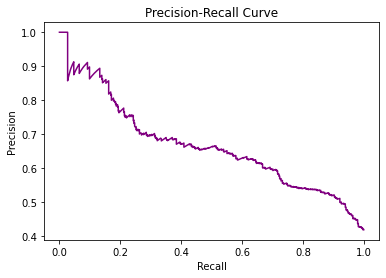

In [5]:
#use logistic regression model to make predictions
y_score = model.predict_proba(X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [6]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


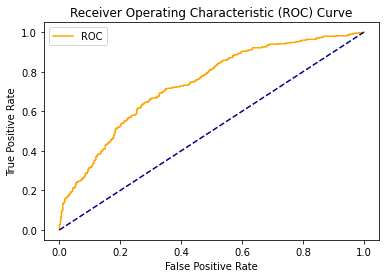

In [7]:
probs = model.predict_proba(X_test)[:, 1]
fper, tper, thresholds = roc_curve(y_test, probs) 
plot_roc_cur(fper, tper)

In [8]:
def plot_summary(idx, shap_values, Xdata):
    shap.plots.waterfall(shap_values[idx])
    plots.prob_barh(model.predict_proba(Xdata)[idx])
    print('Percentile compare to the overall dataset')
    plots.percentile_score(shap_values[idx],Xdata)

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


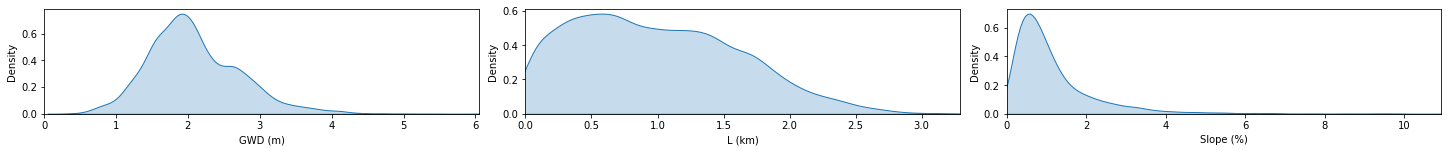

In [9]:
plots.distribution(X_all)

# Local explanations

## Training dataset

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


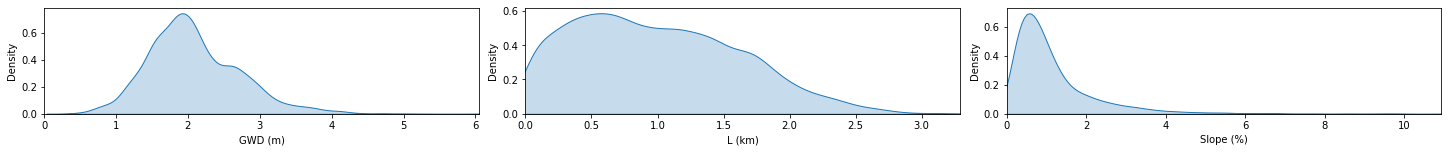

In [10]:
plots.distribution(X_train)

## Case of lateral spreading

In [11]:
# explain the model's predictions using SHAP
# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [12]:
feature_names = ['GWD (m)', 'L (km)', 'Slope (%)']
target_names = ['Lateral Spreading', 'No Lateral Spreading']
lm = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=target_names, discretize_continuous=False)

In [13]:
X_train.reset_index()
X_train_target = X_train_target.reset_index()

In [14]:
X_train_target.loc[X_train_target['Target']==1].loc[X_train_target['L (km)'] < 0.1]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target
33     6658    38476  1.791397  0.058325   1.377933       1
44     6283    27957  1.978356  0.076483   0.840727       1
67     6661    38477  1.791397  0.047181   1.223984       1
78     6364    28689  1.840220  0.063494   0.558119       1
99     6355    27985  1.885435  0.080049   0.190712       1
...     ...      ...       ...       ...        ...     ...
5588   6211     1951  1.580263  0.008480   2.790839       1
5616   6367    24528  1.885435  0.084550   0.190712       1
5620   6849    45014  1.524135  0.054448   0.817829       1
5644   6231      864  1.096305  0.016827   1.745031       1
5646   6411    24746  1.926204  0.062116   0.715357       1

[255 rows x 6 columns]

This is the case where the length to the river is short

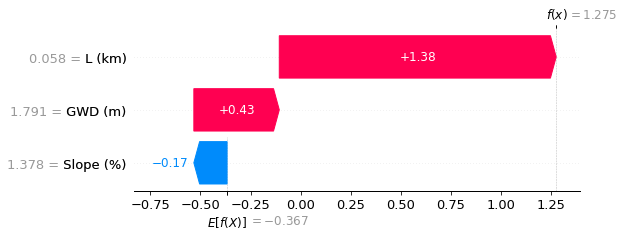

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


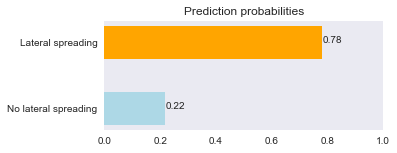

Percentile compare to the overall dataset


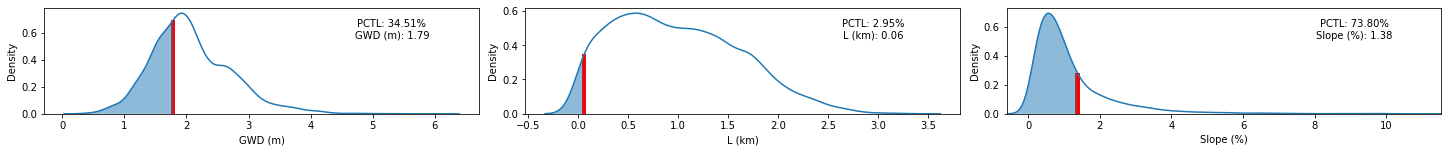

In [15]:
idx = 33
plot_summary(idx, shap_values, X_train)

In [16]:
idx = 33
exp = lm.explain_instance(X_train.iloc[idx], model.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook(predict_proba=False)

## Case of no lateral spreading

In [17]:
X_train_target.loc[X_train_target['Target']==0].loc[X_train_target['L (km)'] > 3]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target
1260   4292     8203  1.671973  3.035505   1.523700       0
1667   4255     8204  1.530668  3.221632   0.943458       0
2472   4269    32250  1.023264  3.069003   0.109984       0
3052   4277    16832  0.669578  3.001999   1.740389       0
3999   4274     7975  1.197707  3.100567   0.354440       0
4601   4252    19563  1.667777  3.289537   0.068539       0
4888   4273    22454  1.058862  3.084513   0.768944       0

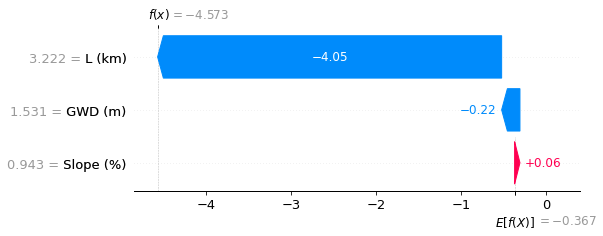

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


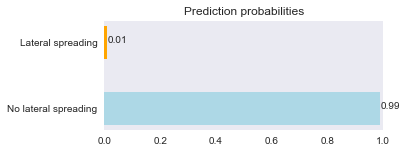

Percentile compare to the overall dataset


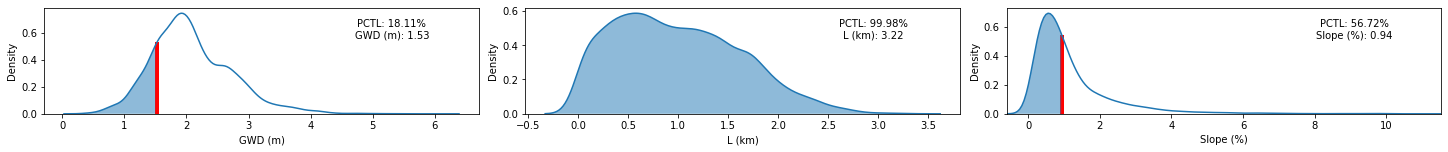

In [18]:
# visualize no lateral spreading prediction explanation
idx = 1667
plot_summary(idx, shap_values, X_train)

In [19]:
idx = 1667
exp = lm.explain_instance(X_train.iloc[idx], model.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook(predict_proba=False)

# Local explanations (Grouped by Type)

## Accuracy

In [20]:
# make prediction
preds = model.predict(X_test)
predictions = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.67%


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [21]:
# Create a dataframe with errors
test_targets = X_test_target['Target']
error = predictions - test_targets
testdf = pd.concat([X_test_target, pd.DataFrame({'error':error})], axis=1)

## True Positive

In [22]:
# Target = 1 (lateral spreading)
tp = testdf[testdf['error'] == 0]
tp = tp[tp['Target'] == 1]

X_true_pos = tp.drop(['Test ID', 'Target', 'error'], axis=1)
tp.head()

Test ID   GWD (m)    L (km)  Slope (%)  Target  error
6223     1105  1.907509  0.018965   2.768473       1      0
6159     6484  1.850592  0.235409   0.563337       1      0
6258    24556  1.783691  0.054444   0.363844       1      0
5092    34610  1.642506  0.943866   6.170671       1      0
233     49594  1.601831  0.329205   2.648838       1      0

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


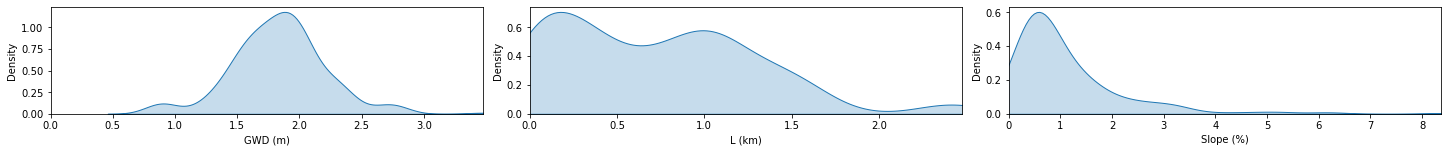

In [23]:
plots.distribution(X_true_pos)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


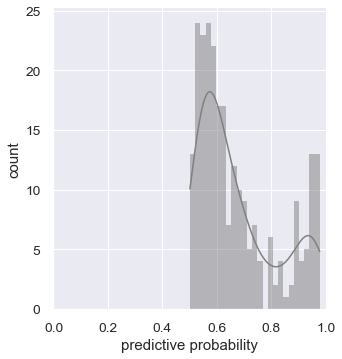

In [24]:
# Prediction probability
prob = model.predict_proba(X_true_pos)
plots.pred_prob(prob[:,1])

In [25]:
# SHAP values of false positive dataset
tp_shap_values = explainer(X_true_pos)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [80]:
pd.set_option('display.max_rows', tp.shape[0]+1)
print(tp)

      Test ID   GWD (m)    L (km)  Slope (%)  Target  error
6223     1105  1.907509  0.018965   2.768473       1      0
6159     6484  1.850592  0.235409   0.563337       1      0
6258    24556  1.783691  0.054444   0.363844       1      0
5092    34610  1.642506  0.943866   6.170671       1      0
233     49594  1.601831  0.329205   2.648838       1      0
3411     2161  2.381904  1.273629   3.090540       1      0
6141    43126  1.501242  0.291715   0.230682       1      0
4324    25469  0.910922  2.436380   0.548276       1      0
2746    21265  1.889897  0.783969   1.524179       1      0
2650    34592  1.635145  0.701107   0.252856       1      0
6910    32580  1.961911  0.224396   0.335389       1      0
7057     3861  2.001158  0.825411   0.161957       1      0
2251    25870  1.621985  0.242980   2.790504       1      0
3428    26090  1.424558  1.047834   0.658659       1      0
3128    10583  1.779284  0.744652   0.395015       1      0
3289     2320  1.724768  1.112572   1.37

### Specific site 34592

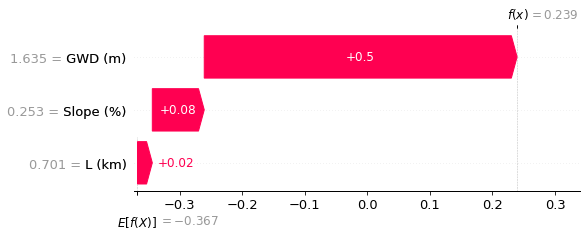

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


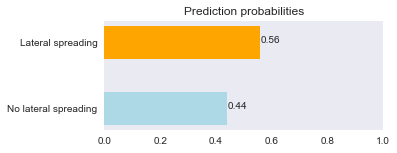

Percentile compare to the overall dataset


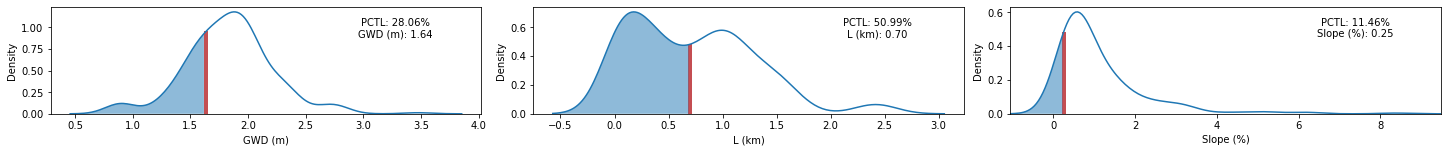

In [83]:
# visualize lateral spreading prediction's explanation
idx = 9
plot_summary(idx, tp_shap_values, X_true_pos)

### Specific site 34610

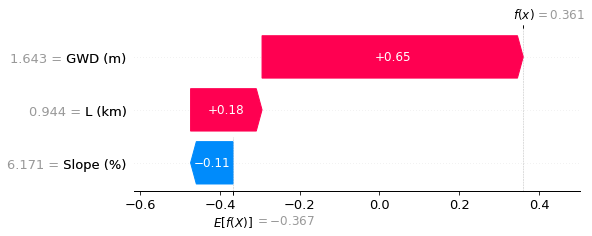

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


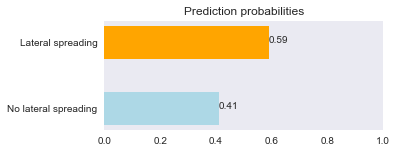

Percentile compare to the overall dataset


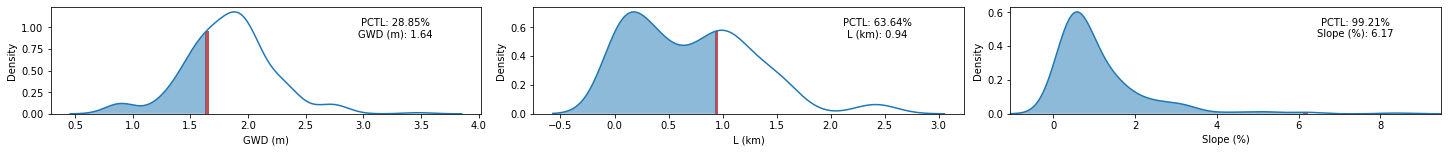

In [75]:
# visualize lateral spreading prediction's explanation
idx = 3
plot_summary(idx, tp_shap_values, X_true_pos)

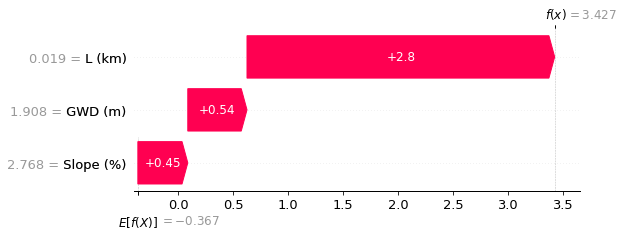

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


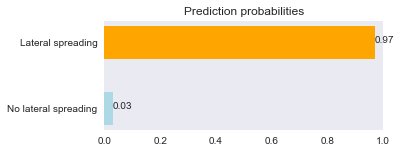

Percentile compare to the overall dataset


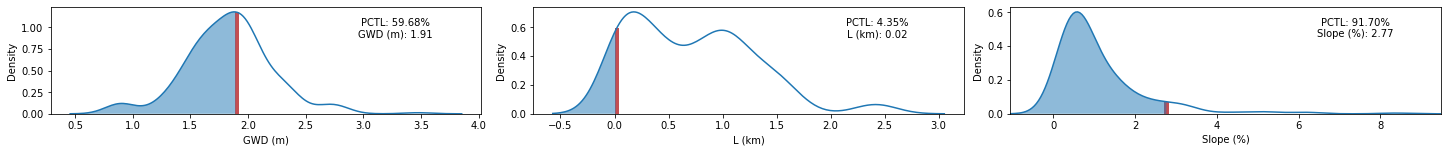

In [27]:
# visualize lateral spreading prediction's explanation
idx = 0
plot_summary(idx, tp_shap_values, X_true_pos)

#### Large distance (L > 2 km), why do we still predict lateral spreading?

In [28]:
tpfar = tp[tp['L (km)'] > 2]
Xfar = tpfar.drop(['Test ID', 'Target', 'error'], axis=1)
tpfar.head()

Test ID   GWD (m)    L (km)  Slope (%)  Target  error
4324    25469  0.910922  2.436380   0.548276       1      0
4256    43421  1.014384  2.364109   2.446507       1      0
4331    24460  0.913812  2.430121   0.624637       1      0
4321     8268  0.905382  2.386378   0.189046       1      0
4263    37405  0.903042  2.476874   0.258458       1      0

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


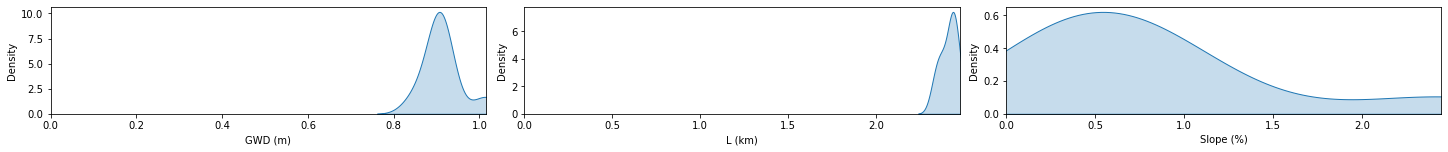

In [29]:
plots.distribution(Xfar)

In [30]:
# SHAP values of X far dataset
xfar_shap_values = explainer(Xfar)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Length is > 2.45 kms but the GWD is closer to the surface

In [31]:
tpfar = tpfar.reset_index()
tpfar.loc[tpfar['L (km)']>2]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
0   4324    25469  0.910922  2.436380   0.548276       1      0
1   4256    43421  1.014384  2.364109   2.446507       1      0
2   4331    24460  0.913812  2.430121   0.624637       1      0
3   4321     8268  0.905382  2.386378   0.189046       1      0
4   4263    37405  0.903042  2.476874   0.258458       1      0
5   4325    25470  0.913812  2.441421   0.415304       1      0
6   4334    22353  0.850854  2.335886   1.011676       1      0
7   4262    37406  0.903042  2.449705   0.875865       1      0

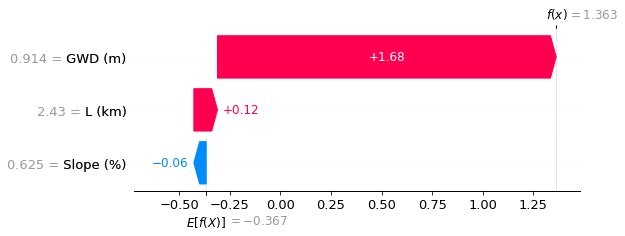

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


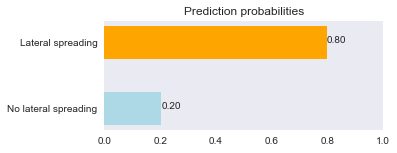

Percentile compare to the overall dataset


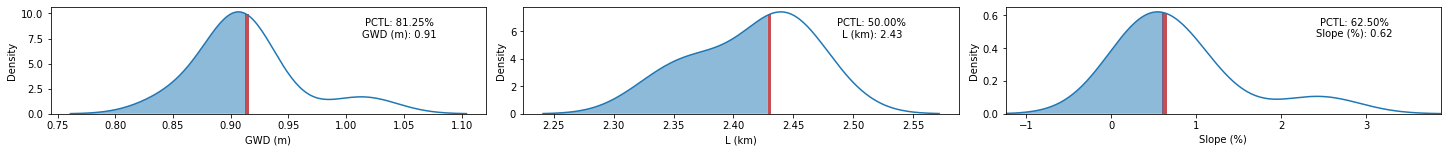

In [32]:
# visualize lateral spreading prediction's explanation
idx = 2
plot_summary(idx, xfar_shap_values, Xfar)

## True Negative

In [94]:
# Target = 0 (no-lateral spreading)
tn = testdf[testdf['error'] == 0]
tn = tn[tn['Target'] == 0]

X_true_neg = tn.drop(['Test ID', 'Target', 'error'], axis=1)
tn = tn.reset_index()
tn.head()

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
0   5940    56009  2.127889  0.391166   0.550378       0      0
1   3300     4643  1.907738  0.549842   1.284769       0      0
2   1642    25559  2.905616  0.324857   1.051902       0      0
3   5451      530  2.775991  0.333152   0.720559       0      0
4   4682    45540  0.734303  0.902587   0.428072       0      0

In [99]:
tn[tn['GWD (m)'] < 1.0]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
4     4682    45540  0.734303  0.902587   0.428072       0      0
25    4316    18981  0.721545  2.639945   0.574291       0      0
100   7272    25467  0.619087  1.844079   0.873595       0      0
130   4320    38513  0.601406  2.550194   0.944349       0      0
148   4226    15766  0.971872  0.209013   0.396518       0      0
164   4265     4960  0.717759  2.717291   0.642314       0      0
197   1729    38406  0.703270  1.834121   9.416513       0      0
210   1171       19  0.974498  1.782891   0.629470       0      0
226   4743     4021  0.737689  0.925875   1.153994       0      0
246   1162    38931  0.974498  1.785952   1.826592       0      0
267   5514    12453  0.954116  1.741183   1.123057       0      0
273   7146      297  0.862280  0.922305   5.225583       0      0
292   4315    43925  0.721545  2.629954   0.647267       0      0
303   4657    45541  0.747059  0.890279   0.163124       0      0
367   4811     9252  0.975441  0.965178   0.262197       0      0
387   4287    14959  0.581712  2.871756   0.366057       0      0
436   4781    12164  0.747551  0.958392   1.372109       0      0
437    154    20941  0.911268  0.888100   0.493149       0      0

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


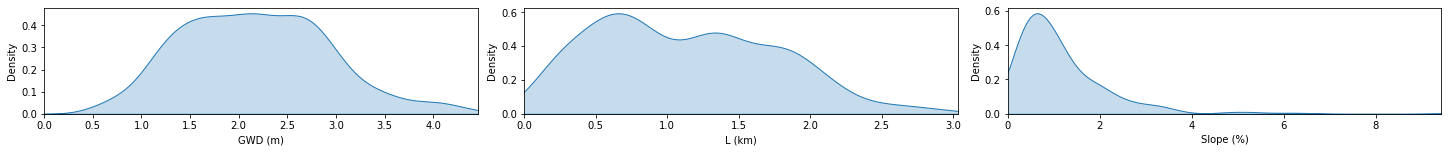

In [34]:
plots.distribution(X_true_neg)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


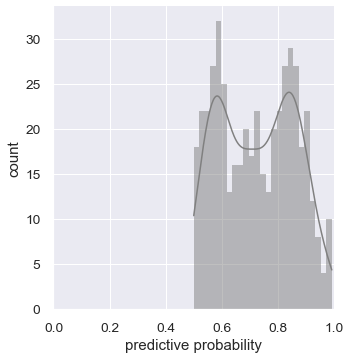

In [35]:
# Prediction probability
prob = model.predict_proba(X_true_neg)
plots.pred_prob(prob[:,0])

In [36]:
# SHAP values of X far dataset
tn_shap_values = explainer(X_true_neg)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Specific site - 297

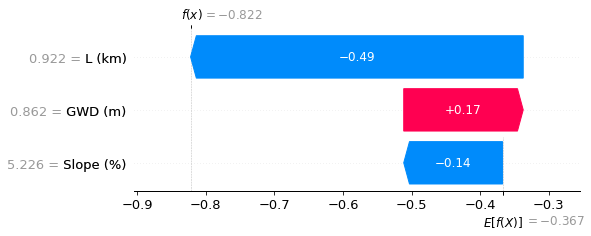

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


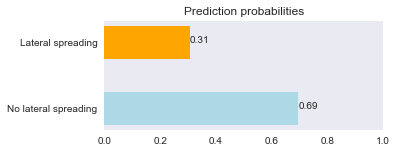

Percentile compare to the overall dataset


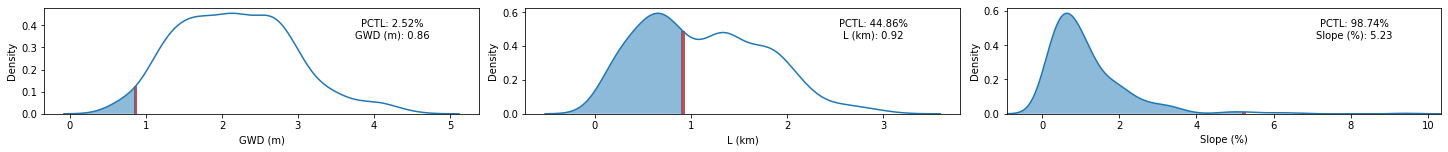

In [100]:
plot_summary(273, tn_shap_values, X_true_neg)

### No lateral spreading due to far away distance

In [37]:
tn.loc[tn['L (km)'] > 2].head()

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
25   4316    18981  0.721545  2.639945   0.574291       0      0
35    915    54309  1.915671  2.206567   1.031268       0      0
58   4503    25067  1.535410  2.125216   0.671203       0      0
60   2246     2776  1.706274  2.109644   0.848471       0      0
62   2180    25799  1.565471  2.226305   0.615057       0      0

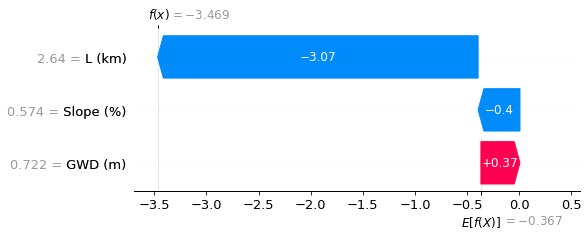

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


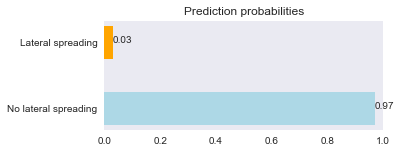

Percentile compare to the overall dataset


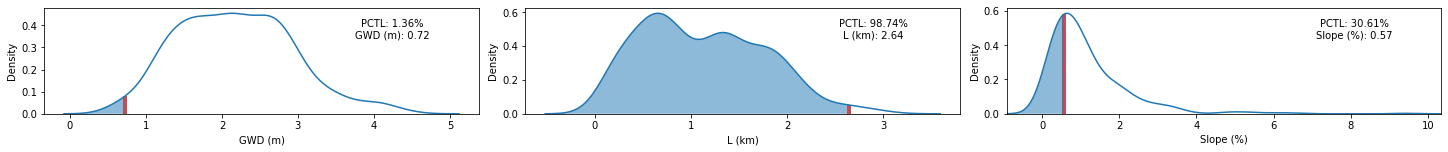

In [38]:
plot_summary(25, tn_shap_values, X_true_neg)

### True negative at short distances (L)

In [39]:
tn.loc[tn['L (km)'] < 0.5].loc[tn['GWD (m)'] > 3]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
5     5816     5083  3.042242  0.149327   0.661831       0      0
39    1568     5661  3.260730  0.306681   1.507082       0      0
49    5772    34434  3.402332  0.170213   0.494863       0      0
51    5764    34428  3.333070  0.182596   0.217464       0      0
53    1904    25621  3.443651  0.169952   1.890133       0      0
78    1906    25081  3.968050  0.317872   3.132067       0      0
104   1928    25634  3.019168  0.193225   3.061359       0      0
256   1572     5725  3.260730  0.325637   2.178741       0      0
302   1908    17849  3.443651  0.168119   1.890133       0      0
341   5776    21428  3.473058  0.113498   0.796042       0      0
388   5532    51781  3.007784  0.480138   0.868730       0      0
424   1631    31785  3.027022  0.200633   1.079101       0      0
440   1867     7114  3.515171  0.128086   2.013518       0      0
455   1619    43730  3.395359  0.158539   1.276369       0      0
464    995    12389  3.177764  0.280596   1.894014       0      0

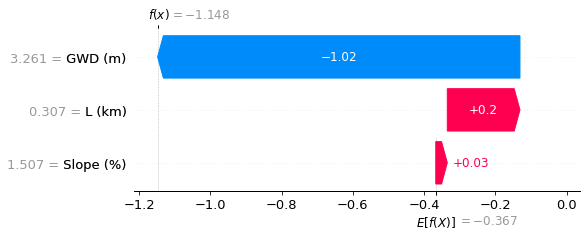

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


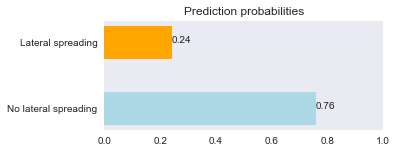

Percentile compare to the overall dataset


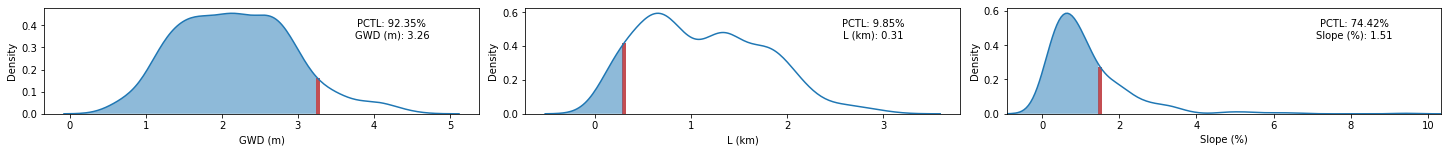

In [40]:
# visualize no lateral spreading prediction's explanation (3)
idx = 39
plot_summary(idx, tn_shap_values, X_true_neg)

# False positive

In [70]:
# Error is 1 means prediction 1 (lateral spreading) while target is 0 (no-lateral spreading)
fp = testdf[testdf['error'] == 1]
X_false_pos = fp.drop(['Test ID', 'Target', 'error'], axis=1)
fp = fp.reset_index()
fp

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
0     7233    32874  1.709347  1.277059   2.697200       0      1
1     6045      849  1.363712  0.015393   3.455205       0      1
2     6503     7689  2.036254  0.402256   0.772629       0      1
3     5801      117  1.152698  0.010883   0.680831       0      1
4        1    15635  1.300896  0.211770   0.905948       0      1
..     ...      ...       ...       ...        ...     ...    ...
136   4089    26127  1.535537  0.236454   0.556948       0      1
137    532     7674  2.294972  1.324627   3.255037       0      1
138    557    11048  2.197297  1.419241   0.759360       0      1
139   4091    11167  1.582196  0.273601   1.404930       0      1
140     15    25645  2.418101  1.496243   1.016844       0      1

[141 rows x 7 columns]

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


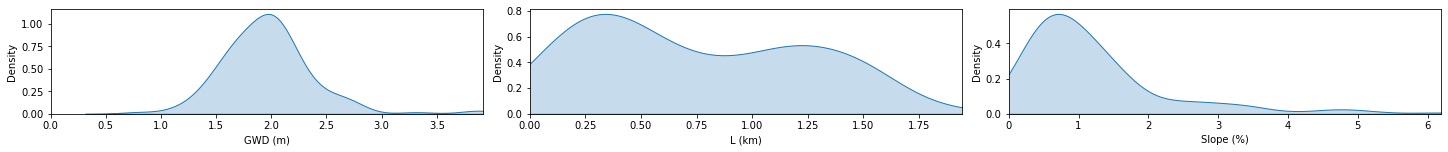

In [42]:
plots.distribution(X_false_pos)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


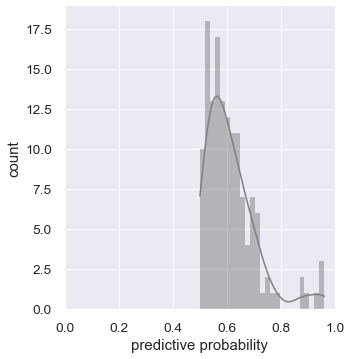

In [43]:
# Prediction probability
prob = model.predict_proba(X_false_pos)
plots.pred_prob(prob[:,1])

In [44]:
# SHAP values of false positive dataset
fp_shap_values = explainer(X_false_pos)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Specific Test ID 7674

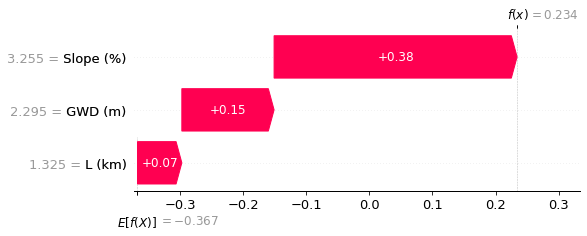

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


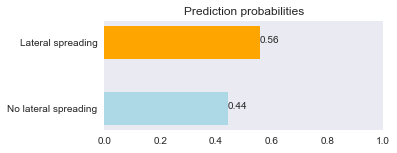

Percentile compare to the overall dataset


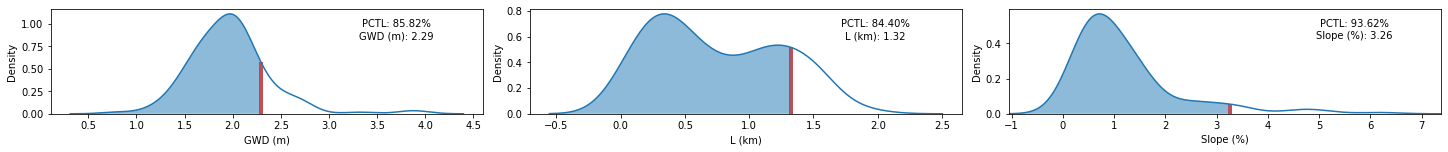

In [71]:
# visualize lateral spreading prediction's explanation - The elevation and slope values are zero
idx=137
plot_summary(idx, fp_shap_values, X_false_pos)

### Fails for close distance to river

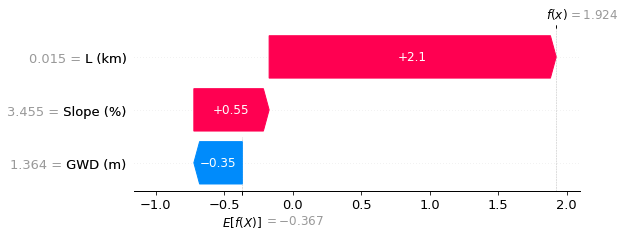

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


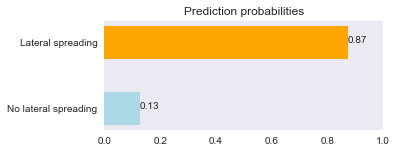

Percentile compare to the overall dataset


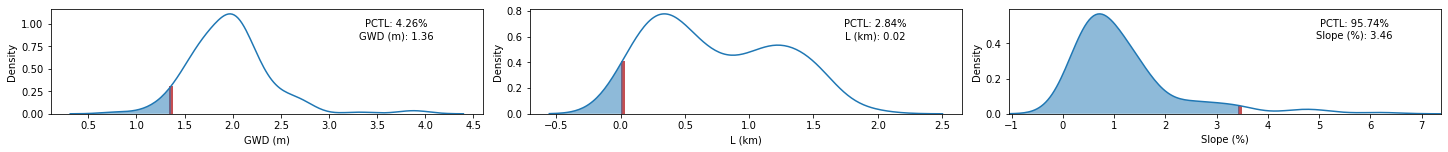

In [45]:
# visualize lateral spreading prediction's explanation - The elevation and slope values are zero
idx=1
plot_summary(idx, fp_shap_values, X_false_pos)

## High slope angle triggered a false positive

In [46]:
fp.loc[fp['Slope (%)'] > 4]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
39    1067    16211  2.657819  1.667745   6.193735       0      1
45    6511    14096  2.640565  0.035327   4.665368       0      1
71     519    25731  3.838498  1.256542   4.789167       0      1
73    5735      523  1.983148  0.155783   5.110602       0      1
106   5535     3764  2.580149  0.257180   4.580277       0      1

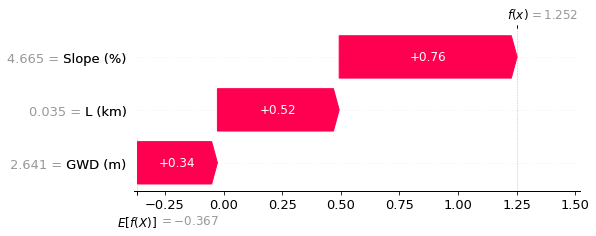

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


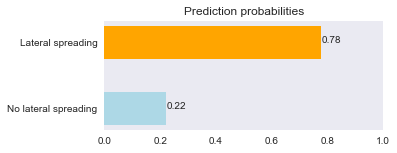

Percentile compare to the overall dataset


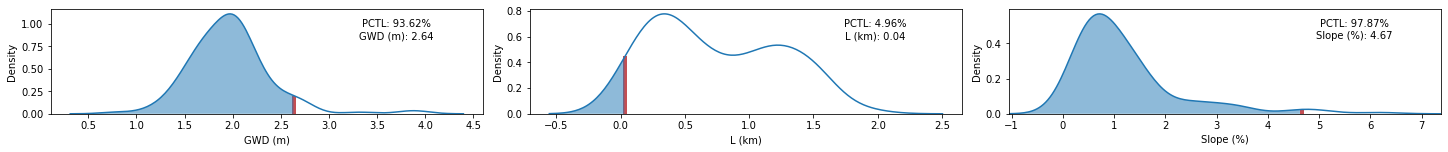

In [47]:
plot_summary(45, fp_shap_values, X_false_pos)

# False negatives

In [72]:
# Error is -1 means prediction 0 (no-lateral spreading) while target is 1 (lateral spreading)
fn = testdf[testdf['error'] == -1]

X_false_neg = fn.drop(['Test ID', 'Target', 'error'], axis=1)
fn = fn.reset_index()
fn

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
0     1681    37333  2.292893  1.950595   0.173166       1     -1
1     3967    54302  1.912122  1.686097   2.076498       1     -1
2     4807      546  1.265184  0.809252   1.024067       1     -1
3     5477    41953  2.783627  0.481081   0.489516       1     -1
4     4291    34717  1.184457  2.256196   0.998763       1     -1
..     ...      ...       ...       ...        ...     ...    ...
187   4844      622  1.550176  2.150808   1.117937       1     -1
188   6594    11046  1.883374  0.604063   0.688107       1     -1
189   3902    30528  1.749310  1.480412   0.709455       1     -1
190   2736    22302  1.526335  0.596211   0.862792       1     -1
191   3550    41157  2.645971  1.435608   0.078436       1     -1

[192 rows x 7 columns]

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


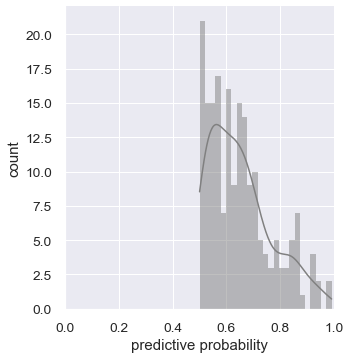

In [49]:
# Prediction probability
prob = model.predict_proba(X_false_neg)
plots.pred_prob(prob[:,0])

In [50]:
# SHAP values of false negative dataset
fn_shap_values = explainer(X_false_neg)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Specific site 546

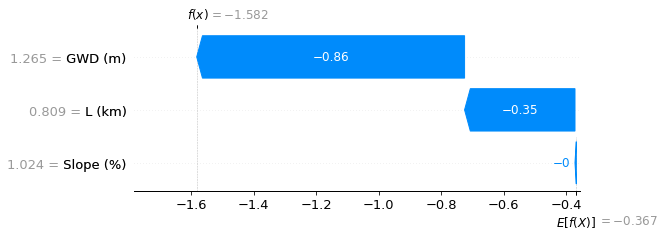

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


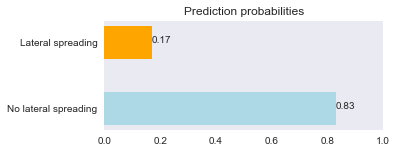

Percentile compare to the overall dataset


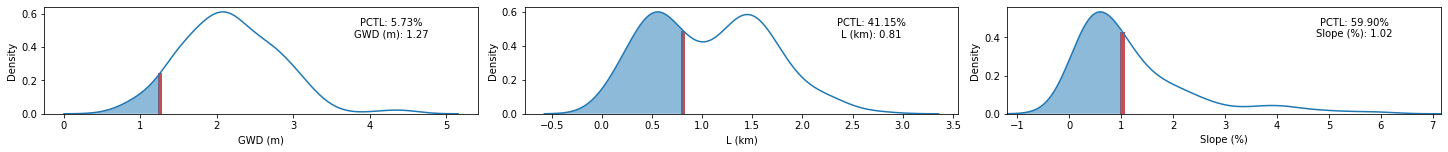

In [74]:
# The elevation and slope values are zero

idx=2
plot_summary(idx, fn_shap_values, X_false_neg)

## Specific site 37333

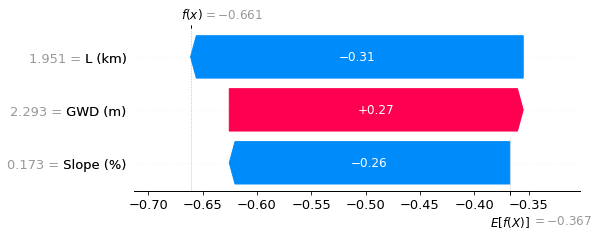

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


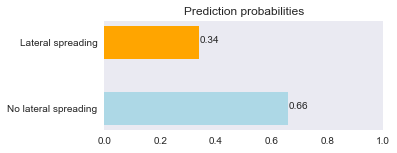

Percentile compare to the overall dataset


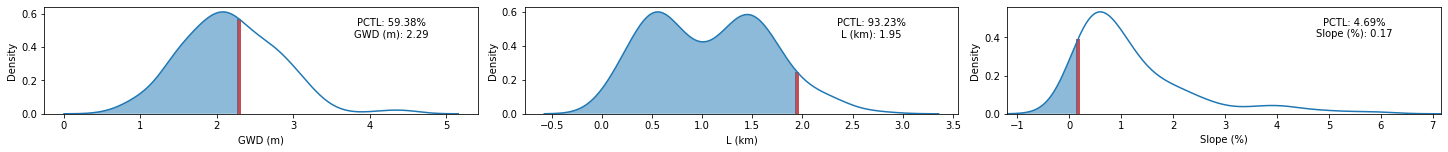

In [73]:
# The elevation and slope values are zero

idx=0
plot_summary(idx, fn_shap_values, X_false_neg)

### Distance is too far

In [51]:
fn.loc[fn['L (km)'] > 2]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
4     4291    34717  1.184457  2.256196   0.998763       1     -1
11    4330     4956  1.092189  2.315552   0.971153       1     -1
32    1787    24628  2.314934  2.317660   2.562188       1     -1
63    4515     4601  1.654792  2.018813   0.608391       1     -1
69    7155    48656  2.302286  2.739961   0.545546       1     -1
72    4896    25200  2.101239  2.001274   1.339319       1     -1
93    4906     3940  1.772278  2.253003   0.366992       1     -1
94    5268    45542  2.642566  2.012517   0.563027       1     -1
96    4258    19283  0.672930  2.426664   0.466489       1     -1
102   4834    12457  2.072486  2.269473   0.303873       1     -1
113   7084    34326  2.128562  2.141897   1.513339       1     -1
187   4844      622  1.550176  2.150808   1.117937       1     -1

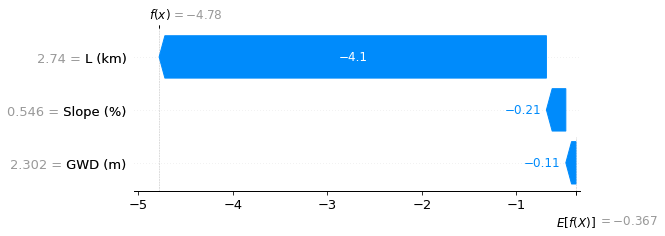

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


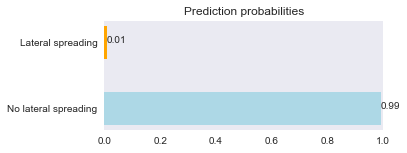

Percentile compare to the overall dataset


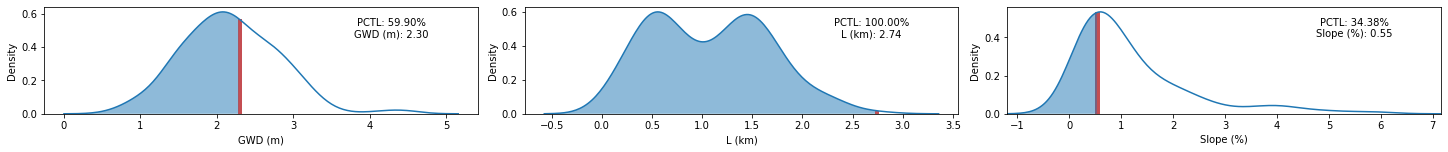

In [52]:
# The elevation and slope values are zero
idx=69
plot_summary(idx, fn_shap_values, X_false_neg)

### Distance is close but predicts false negative value

In [53]:
fn.loc[fn['L (km)'] < 0.5]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
3     5477    41953  2.783627  0.481081   0.489516       1     -1
6     5490    41954  2.874965  0.466306   0.480653       1     -1
7     2097    32959  1.930622  0.465034   0.900893       1     -1
9     5575    50320  2.425169  0.325109   0.492121       1     -1
17    4055    48880  2.358732  0.417065   0.987149       1     -1
20    6953    43706  2.145298  0.162812   0.452945       1     -1
21     295     2915  3.045438  0.450243   1.469180       1     -1
25    5762    15614  2.341032  0.334529   2.211929       1     -1
26    2957    23932  2.163261  0.290383   0.672333       1     -1
31    5613      529  2.252130  0.258286   1.024506       1     -1
38    1965    49781  2.933140  0.150941   0.737199       1     -1
41    3117    50042  2.126513  0.325654   0.288891       1     -1
43    5657    23422  2.601460  0.379507   0.136559       1     -1
45     294    41164  2.883703  0.483083   1.019211       1     -1
50    5926    29016  2.398019  0.152385   1.968075       1     -1
56    5289    44020  2.978290  0.461283   0.230742       1     -1
59    6912    14217  1.948803  0.127597   0.900676       1     -1
70    5591    15788  3.143854  0.082160   0.378106       1     -1
76    6987     1423  1.485332  0.044273   1.209664       1     -1
77    5537    30924  3.007784  0.461044   0.298616       1     -1
79    3003     4786  2.371197  0.423154   0.688460       1     -1
85    5895     7988  2.419171  0.194956   1.039184       1     -1
90    6186    15095  2.143462  0.058920   2.041227       1     -1
92    3975     4080  1.876147  0.353332   0.159985       1     -1
95    6960    43696  2.204325  0.202820   1.038369       1     -1
104   5546    25503  2.971129  0.430836   0.872064       1     -1
105   3887    18579  2.659509  0.412030   3.334707       1     -1
106   5738    15613  2.340762  0.322193   1.703968       1     -1
112   5977    15688  1.594759  0.418481   0.376607       1     -1
117   2256     2099  2.075026  0.465872   0.042615       1     -1
128   2077    32938  2.058806  0.456720   0.594271       1     -1
137   6979    15776  0.872733  0.199694   0.602918       1     -1
144    227     1420  0.902403  0.183598   0.594641       1     -1
145   5927     9018  1.901494  0.286622   0.084138       1     -1
152   2424     8102  1.265591  0.473375   0.464927       1     -1
161   5385    11216  2.989932  0.292802   0.964330       1     -1
171   2070    32937  2.058806  0.462337   0.594271       1     -1
178   2099    32936  1.930622  0.477522   0.900893       1     -1
179    780    22278  2.174715  0.374807   1.209491       1     -1
182   1979     5114  2.596913  0.209539   0.356467       1     -1

### Deeper GWD

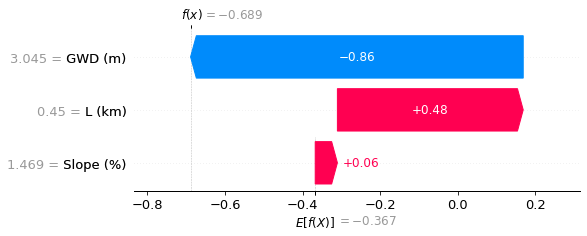

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


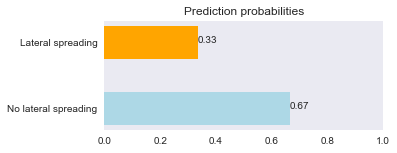

Percentile compare to the overall dataset


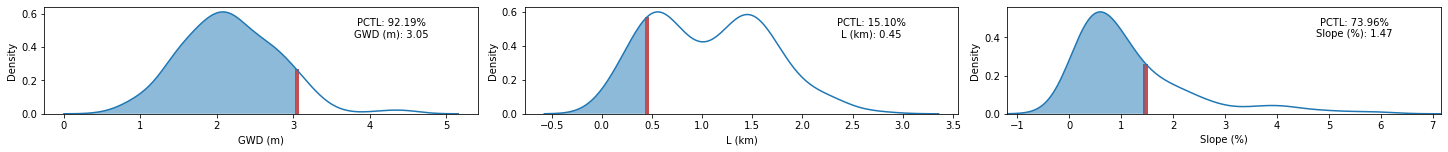

In [54]:
idx = 21
plot_summary(idx, fn_shap_values, X_false_neg)

#### Shallow GWD < 2m 

In [55]:
fn.loc[fn['L (km)'] < 0.5].loc[fn['GWD (m)'] < 2]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
7     2097    32959  1.930622  0.465034   0.900893       1     -1
59    6912    14217  1.948803  0.127597   0.900676       1     -1
76    6987     1423  1.485332  0.044273   1.209664       1     -1
92    3975     4080  1.876147  0.353332   0.159985       1     -1
112   5977    15688  1.594759  0.418481   0.376607       1     -1
137   6979    15776  0.872733  0.199694   0.602918       1     -1
144    227     1420  0.902403  0.183598   0.594641       1     -1
145   5927     9018  1.901494  0.286622   0.084138       1     -1
152   2424     8102  1.265591  0.473375   0.464927       1     -1
178   2099    32936  1.930622  0.477522   0.900893       1     -1

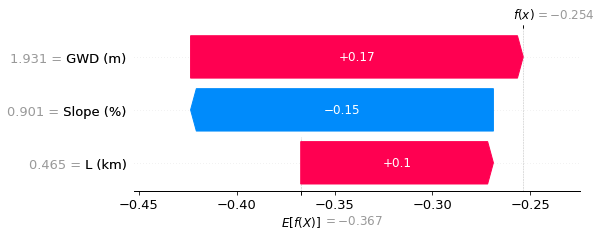

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


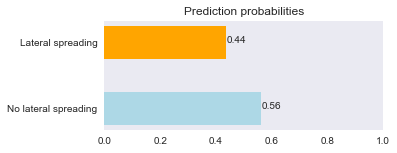

Percentile compare to the overall dataset


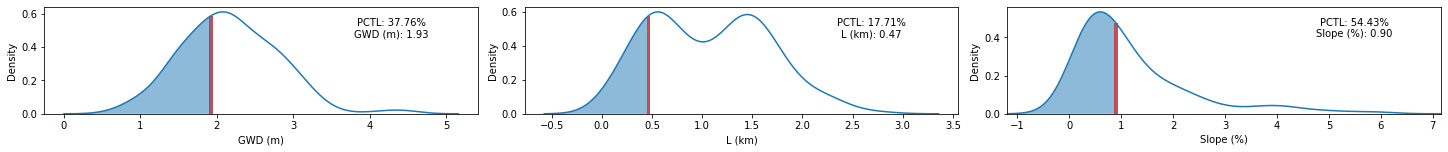

In [56]:
idx = 7
plot_summary(idx, fn_shap_values, X_false_neg)

# Global explanations

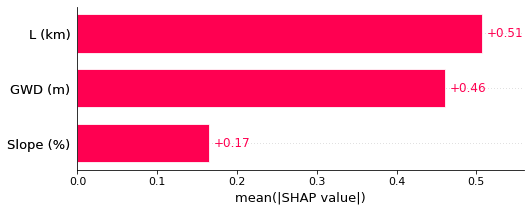

In [57]:
shap.plots.bar(shap_values)

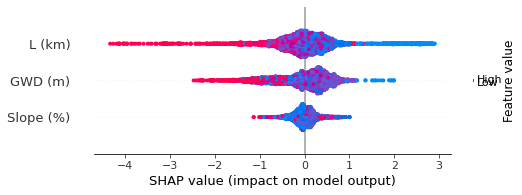

In [58]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

## True Positives

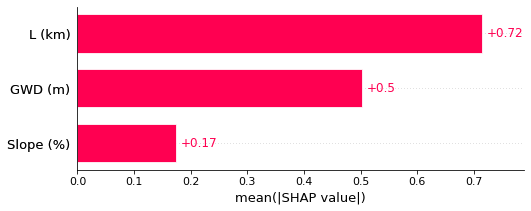

In [59]:
shap.plots.bar(tp_shap_values)

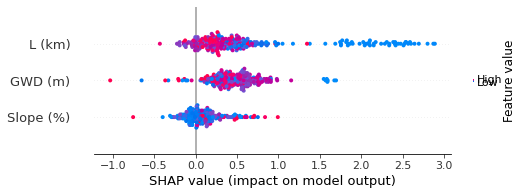

In [60]:
# summarize the effects of all the features
shap.plots.beeswarm(tp_shap_values)

### True negative

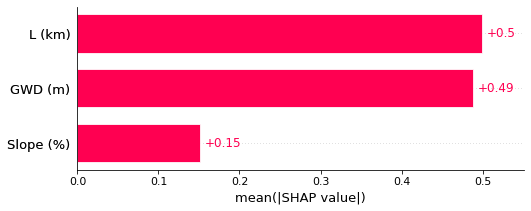

In [61]:
shap.plots.bar(tn_shap_values)

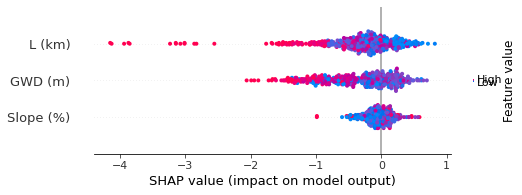

In [62]:
shap.plots.beeswarm(tn_shap_values)

### False positives

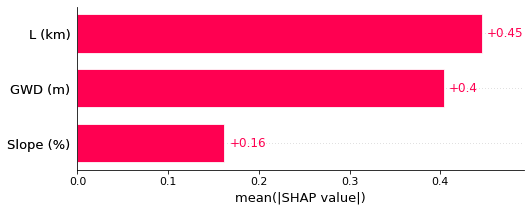

In [63]:
shap.plots.bar(fp_shap_values)

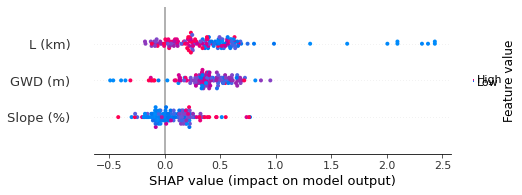

In [64]:
shap.plots.beeswarm(fp_shap_values)

### False Negative

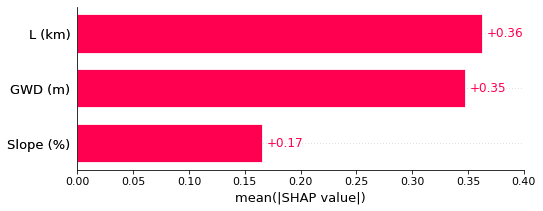

In [65]:
shap.plots.bar(fn_shap_values)

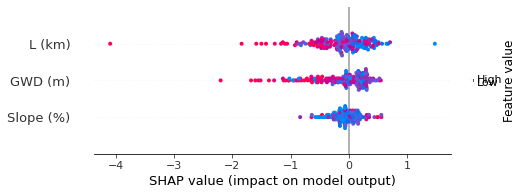

In [66]:
shap.plots.beeswarm(fn_shap_values)

# Feature relations

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


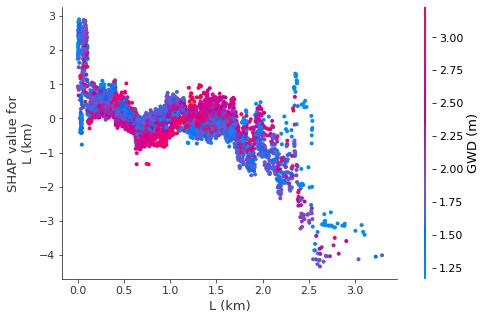

In [67]:
# explain the model's predictions using SHAP
# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.dependence_plot('L (km)', shap_values, X_train, interaction_index="GWD (m)")

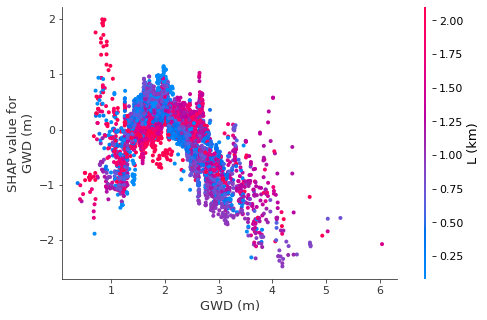

In [68]:
shap.dependence_plot('GWD (m)', shap_values, X_train)

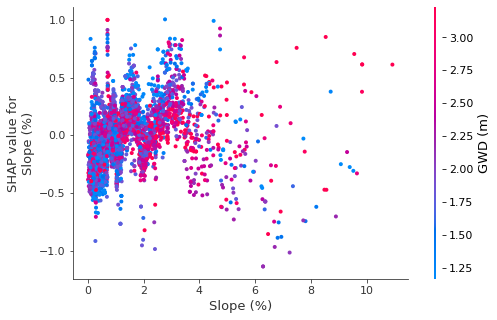

In [69]:
shap.dependence_plot('Slope (%)', shap_values, X_train)

# Improving the model 7674